# Learning Parameters of Heuristics

In the schema matcher we use heuristics to "rate" skipgrams, in order to distinguish schema instances from non-instances.
The rating function is a linear combination of the values returned by the individual heuristics.
The weights of this linear combination should be chosen such that instances get a high rating and non-instances get a low rating.

The matcher can be understood as a classifier that assigns a binary label to skipgrams ("instance" vs. "non-instnace").
As skipgrams are not considered independently but in groups of overlapping instances, this classification is not consistent among skipgrams.
However, we still want the rating function to give the best rating to the most plausible skipgram in every group und worse ratings to all others, which can also be achieved (at least approximately) if we assume independence between skipgrams and use a standard technique to fit the rating function.

In [1]:
import Pkg; Pkg.activate("..")
using Revise # install if necessary
using DigitalMusicology
using MusicologyPlots
using DataFrames
using GLM

┌ Info: Precompiling MusicologyPlots [c9d89ec8-a6c4-11e8-1629-537f3e81f650]
└ @ Base loading.jl:1187


In [2]:
corpuspath = "/home/chfin/Uni/phd/data/csapp/mozart-piano-sonatas/"
DigitalMusicology.usekern(corpuspath)

DigitalMusicology.Corpora.Kern.KernCorpus("/home/chfin/Uni/phd/data/csapp/mozart-piano-sonatas/", ["sonata01-1", "sonata01-2", "sonata01-3", "sonata02-1", "sonata02-2", "sonata02-3", "sonata03-1", "sonata03-2", "sonata03-3", "sonata04-1"  …  "sonata14-3", "sonata15-1", "sonata15-2", "sonata15-3", "sonata16-1", "sonata16-2", "sonata16-3", "sonata17-1", "sonata17-2", "sonata17-3"])

In [3]:
include("../src/polygrams.jl")

Main.Polygrams

## Model Definition

The heuristics model is defined by its features/heuristics

In [5]:
pieceid = "sonata03-3"
notes = getpiece(pieceid, :notes_wholes);
barlen = Polygrams.piecebarlen(pieceid);
timesigs = getpiece(pieceid, :timesigs);

In [6]:
fonte2v = @midi [[0, 6], [1, 4], [10, 4], [11, 3]]

4-element Array{Array{MidiPitch,1},1}:
 [0, 6] 
 [1, 4] 
 [10, 4]
 [11, 3]

In [4]:
beatfactor = denominator(content(timesigs[1]))
featurefs = [
    poly -> beatfactor * Polygrams.totalduration(poly), # duration
    Polygrams.voicedist,                                # voice dist
    poly -> beatfactor * Polygrams.instageskip(poly)    # stage skip
    #, poly -> Polygrams.polymweight(poly, timesigs) # metric weight
]
featurekeys = [:dur, :vdist, :skip]
modelform = @formula(label ~ dur + vdist + skip)

Formula: label ~ dur + vdist + skip

## Data Generation

We don't have real schema annotations yet, so we create a small dataset manually.
Fortunately, there is only a few instances of a certain schema variant in a dataset,
so we can use the old, hand-fitted matcher to find and name those instances.
All remaining skipgrams will be the non-instances, which will give us a few ten-thousand data points.

In [7]:
polyitr = Polygrams.schemamatches(notes, [fonte2v], barlen, barlen);
polys = collect(polyitr);
length(polys)

24106

In [33]:
best = Polygrams.bestrated(polys, featurefs, [1, -1//12, -2])
length(best)

13

Using the old matcher, 13 instances have been found, some of which should still be false positives.
Therefore, we look at all matches and select only the true positives:

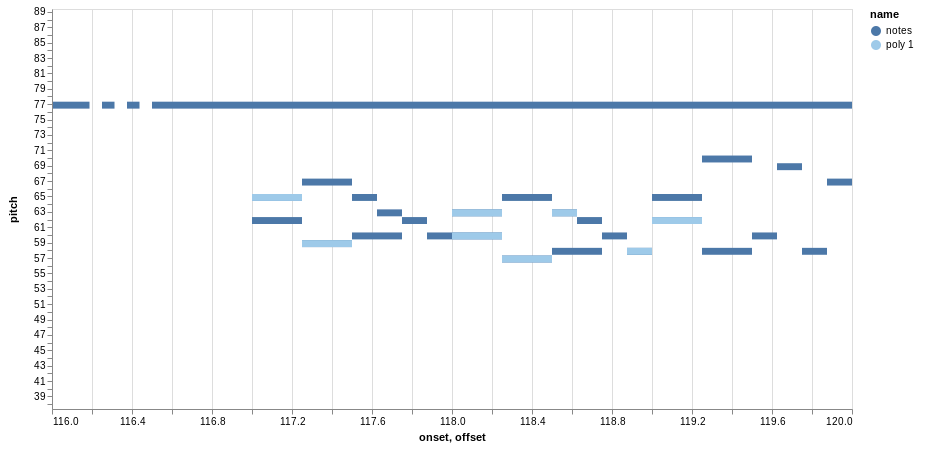

In [25]:
plotpolygrams(notes, best[[10]], start=116, stop=120)

In [10]:
truepositives = vcat(best[[1,2,3,4,6,7,8,9]], polys[[17956,18027]]);  # wrong prediction: 10 (117,118), 11 (122,123)

In [11]:
# Polygrams.savepolys("../data/truepositives/sonata03-3.jld2", truepositives)

Now that we know the true positives, we can generate a dataframe where each row holds the class label and the heuristics features for one skipgram.

In [12]:
keywords = vcat(featurekeys, [:label])
features = vcat(featurefs, [p -> p in truepositives])
data = Polygrams.genfeatures(polys, keywords, features)

,dur,label,skip,vdist
1,9//2,true,3//2,8
2,15//4,false,7//4,32
3,7//2,false,7//4,32
4,19//4,false,11//4,20
5,4//1,false,3//1,44
6,15//4,false,3//1,44
7,15//4,false,7//4,20
8,3//1,false,2//1,44
9,11//4,false,2//1,44
10,7//2,false,7//4,20


# Fitting the Model

We use a logit regression to fit the coefficients of the heuristics.

In [13]:
model = glm(modelform, data, Binomial(), LogitLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: label ~ 1 + dur + vdist + skip

Coefficients:
             Estimate Std.Error    z value Pr(>|z|)
(Intercept)  0.621377   298.918 0.00207875   0.9983
dur           6.49704   1.79292    3.62372   0.0003
vdist        -2.24689   37.3597 -0.0601421   0.9520
skip          -5.8502    1.5768   -3.71017   0.0002


In [14]:
coef(model)

4-element Array{Float64,1}:
  0.6213766352307322
  6.497036133935839 
 -2.2468906587902935
 -5.850197453271407 

Let's try the computed coefficients and see if they lead to the correct schema matches

In [15]:
best2 = Polygrams.bestrated(polys, featurefs, coef(model)[[2,3,4]])
length(best2)

13

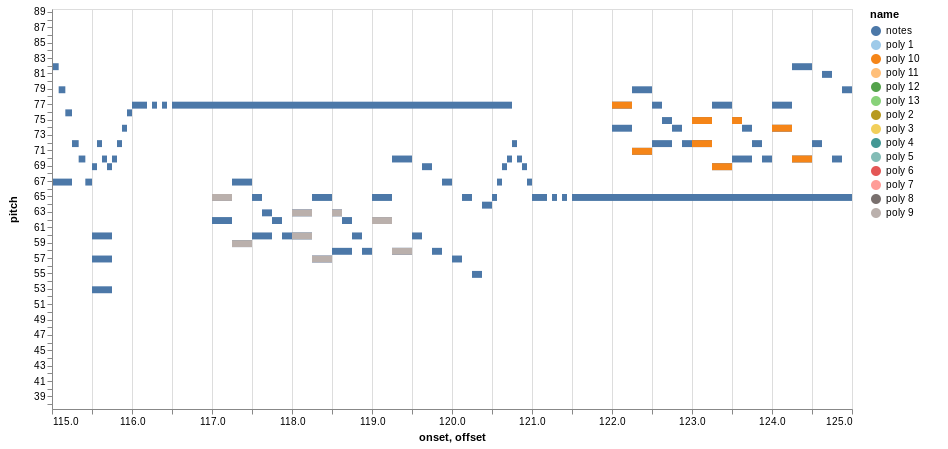

In [32]:
plotpolygrams(notes, best2, start=115, stop=125)

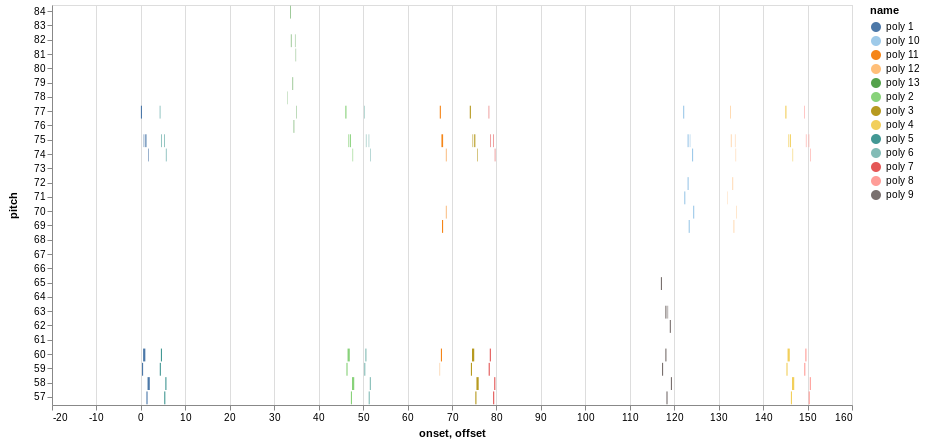

In [17]:
plotpolygrams([], best2) #, start=0, stop=10)